In [73]:
import os, glob
from io import open
import string 
import unicodedata
import torch
import torch.nn as nn
import random
import time, math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load data

In [3]:
filenames=glob.glob('data/names/*.txt')
all_letters = string.ascii_letters + " .,;'"

In [4]:
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s)
    if unicodedata.category(c) != 'Mn' and c in all_letters)
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(l) for l in lines]
def processFile(filename):
    category = os.path.splitext(os.path.basename(filename))[0]
    lines = readLines(filename)
    return (category, lines)

In [5]:
category_lines_dict=dict([processFile(filename) for filename in filenames])
categories = list(category_lines_dict.keys())

In [6]:
category_lines_dict['Russian'][-2004]

'Tcharuhin'

In [7]:
def letterToIndex(l):
    return all_letters.find(l)
def lineToTensor(line):
    tensor = torch.zeros(len(line),1,len(all_letters))
    for i,l in enumerate(line):
        tensor[i][0][letterToIndex(l)]=1
    return tensor

# Define network

In [140]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2hpre = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2opre = nn.Linear(input_size + hidden_size, input_size + hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        
        hidden_pre = self.i2hpre(combined)
        hidden_pre= self.tanh(hidden_pre)
        hidden = self.i2h(hidden_pre)
        
        output_pre = self.i2opre(combined)
        output_pre = self.tanh(output_pre)
        output = self.i2o(output_pre)
        
        output = self.softmax(output)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.softmax(output)
        
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


# Util

In [141]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    cat_i = top_i[0].item()
    return categories[cat_i], cat_i
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    cat_i = random.randint(0, len(categories)-1)
    category = categories[cat_i]
    line = randomChoice(category_lines_dict[category])
    cat_tensor = torch.tensor([cat_i],dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, cat_tensor, line_tensor

In [142]:
randomChoice(["a","b","c"])

'b'

# Train

In [143]:
rnn = RNN(len(all_letters), 128, len(categories))
criterion = nn.NLLLoss()
learning_rate = 0.005

In [144]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item()

In [145]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '{}m {:.2f}s'.format(m, s)

In [146]:
n_iters = 1000000
print_every = 5000
plot_every = 1000

In [147]:
timeSince(start)

'0m 12.05s'

In [148]:
current_loss = 0
all_losses = []
start = time.time()
for iter in range(n_iters):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('{} {}% ({}) {:.2f} {} / {} {}'.format(iter, iter/n_iters*100.0,
                                                     timeSince(start), loss,
                                                     line, guess, correct))
    if iter % plot_every == 0:
        all_losses.append(current_loss/plot_every)
        current_loss=0
timeSince(start)

0 0.0% (0m 0.01s) 2.86 Suk / Irish ✗ (Korean)
5000 0.5% (0m 9.15s) 2.93 Bonner / German ✗ (French)
10000 1.0% (0m 19.60s) 2.09 Fuwa / Vietnamese ✗ (Japanese)
15000 1.5% (0m 28.70s) 2.10 Said / Vietnamese ✗ (Arabic)
20000 2.0% (0m 37.54s) 1.84 Hoyle / Scottish ✗ (English)
25000 2.5% (0m 47.80s) 1.09 Simoes / Portuguese ✓
30000 3.0% (0m 56.92s) 0.29 Soares / Portuguese ✓
35000 3.5000000000000004% (1m 5.79s) 0.92 Mackay / Scottish ✓
40000 4.0% (1m 14.97s) 0.87 Qing / Chinese ✓
45000 4.5% (1m 24.60s) 4.60 Gajos / Greek ✗ (Polish)
50000 5.0% (1m 33.62s) 0.32 Shimada / Japanese ✓
55000 5.5% (1m 42.71s) 1.61 Murray / Arabic ✗ (English)
60000 6.0% (1m 52.74s) 0.43 Akrivopoulos / Greek ✓
65000 6.5% (2m 1.57s) 0.80 Kunikida / Japanese ✓
70000 7.000000000000001% (2m 10.83s) 1.93 Mcguire / French ✗ (Irish)
75000 7.5% (2m 20.76s) 1.11 Ottley / English ✓
80000 8.0% (2m 29.69s) 1.49 Gaubrich / Irish ✗ (Russian)
85000 8.5% (2m 38.69s) 3.20 Gottlieb / Czech ✗ (German)
90000 9.0% (2m 48.52s) 1.90 Merckx

'29m 34.22s'

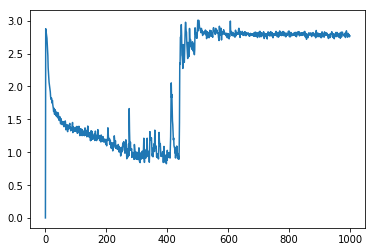

In [149]:
plt.figure()
plt.plot(all_losses)

# Confusion matrix

In [150]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

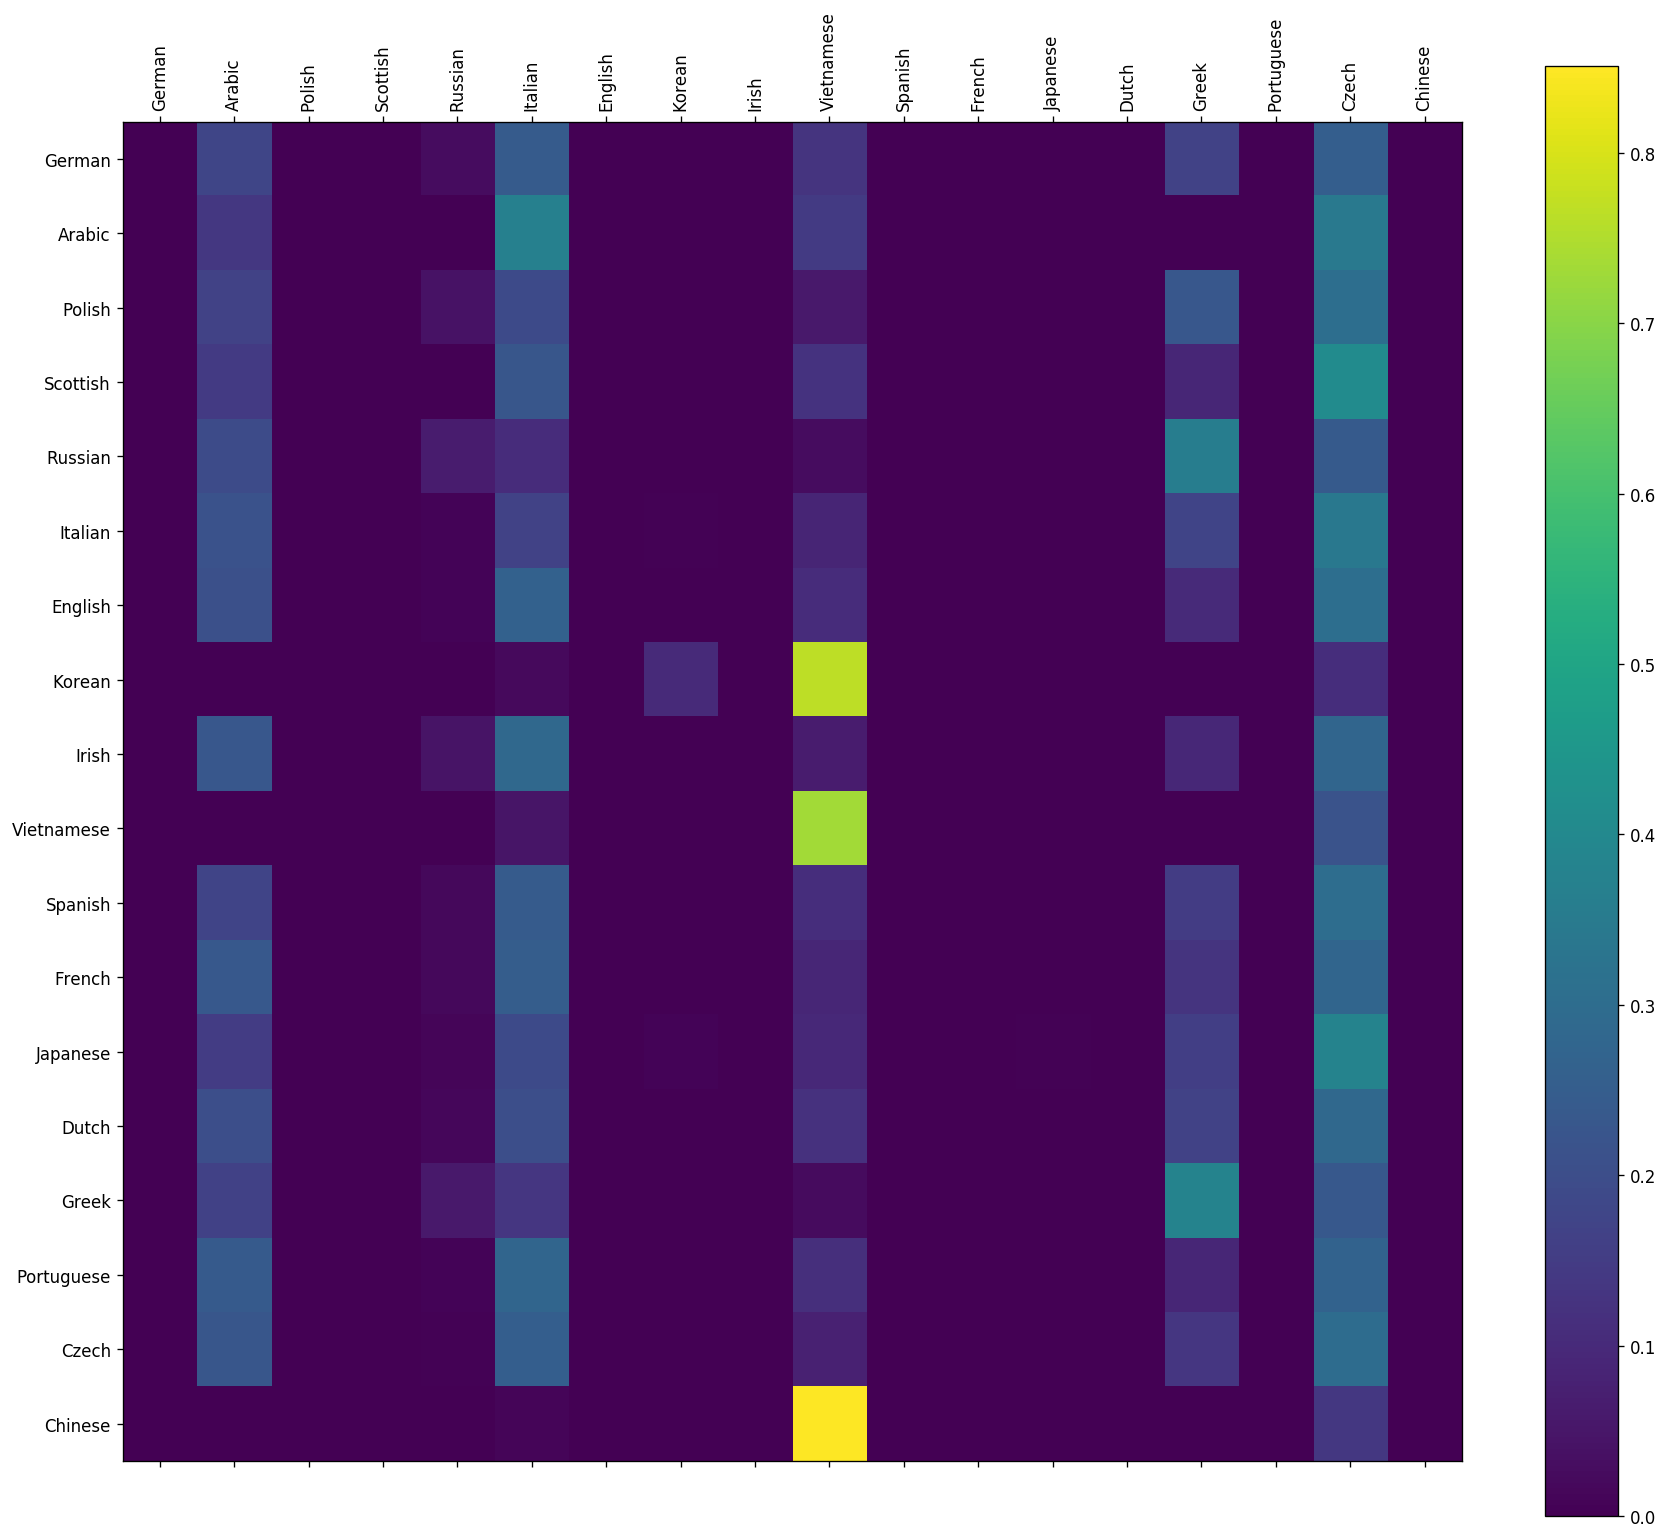

In [151]:
confusion = torch.zeros(len(categories), len(categories))
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = categories.index(category)
    confusion[category_i][guess_i] += 1
for i in range(len(categories)):
    confusion[i] = confusion[i]/confusion[i].sum()

fig = plt.figure(figsize=(18,16), dpi=120)
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)
ax.set_xticklabels([''] + categories, rotation=90)
ax.set_yticklabels([''] + categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

In [152]:
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)


In [130]:
(category, guess)

('Japanese', 'Chinese')